# Sigma Wedge Hackathon


# Collection of Data
Obtain the closing prices for each trading day within the specified period (January 1, 2023, to December 31, 2023). Closing prices are a critical piece of data for financial analysis and trading strategy development, as they represent the final price at which a stock is traded during a trading session

In [ ]:
from quantrocket.zipline import create_usstock_bundle
create_usstock_bundle("usstock-free-1min", free=True)

In [106]:
from quantrocket.zipline import ingest_bundle
ingest_bundle("usstock-free-1min")

{'status': 'the data will be ingested asynchronously'}

In [107]:
from quantrocket.license import set_license
set_license('e28e6e06-e03d-11ee-ac0b-75a7adda123c')

{'licensekey': 'e28e........123c', 'software_license': {}}

In [108]:
from quantrocket.master import collect_usstock_listings
collect_usstock_listings()

{'status': 'success', 'msg': 'already up-to-date'}

In [ ]:
from quantrocket.master import get_securities
securities = get_securities(symbols='AAPL', fields=['Sid','Symbol','Exchange'], vendors='usstock')
securities

In [ ]:
aapl=securities.index[0]

In [6]:
aapl

'FIBBG000B9XRY4'

In [ ]:
from quantrocket import get_prices
data = get_prices("usstock-free-1min", data_frequency='daily', sids=aapl, start_date='2023-01-01', end_date='2023-12-31', fields="Close")
import pandas as pd
data.to_csv("daily_closing_prices.csv")

In [46]:
import pandas as pd
df=pd.read_csv("daily_closing_prices.csv")
df.rename(columns={'FIBBG000B9XRY4': 'close price'}, inplace=True)
df

Field        Date  close price
0    Close  2023-01-03      124.375
1    Close  2023-01-04      125.658
2    Close  2023-01-05      124.325
3    Close  2023-01-06      128.900
4    Close  2023-01-09      129.427
..     ...         ...          ...
245  Close  2023-12-22      193.600
246  Close  2023-12-26      193.050
247  Close  2023-12-27      193.150
248  Close  2023-12-28      193.580
249  Close  2023-12-29      192.530

[250 rows x 3 columns]

# Line Chart

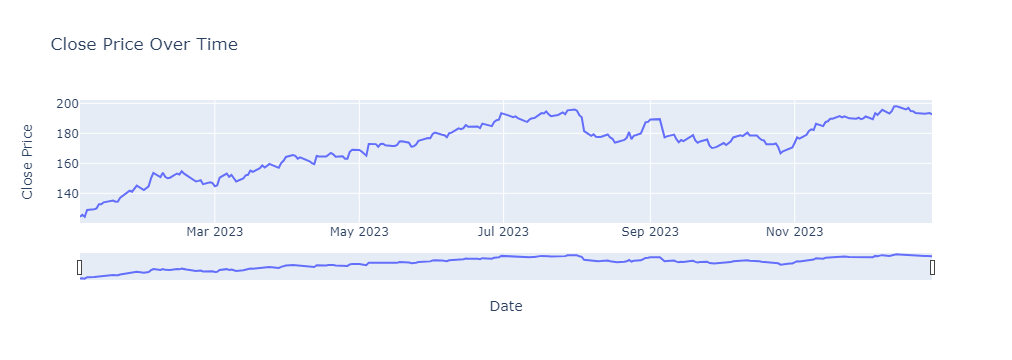

In [47]:
import plotly.express as px
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create an interactive line chart
fig = px.line(df, x='Date', y='close price', title='Close Price Over Time')

# Enhance the chart with additional options
fig.update_layout(xaxis_title='Date', yaxis_title='Close Price', hovermode='x')
fig.update_xaxes(rangeslider_visible=True)

# Show the plot
fig.show()

# Distribution of Daily Returns

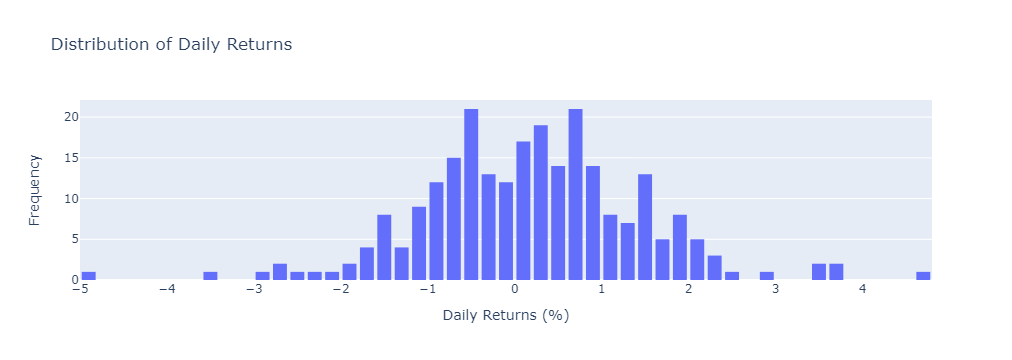

In [48]:
df.sort_values('Date', inplace=True)

# Instead of directly assigning the calculated values to a slice, use .loc to ensure the operation is done on the original DataFrame
# Calculate daily returns as percentage change in 'close price' and safely assign it back to the DataFrame
df.loc[:, 'Daily Returns'] = df['close price'].pct_change() * 100

# Drop the first row since its daily return will be NaN
df.dropna(inplace=True)

# Create a histogram to visualize the distribution of daily returns
fig = px.histogram(df, x='Daily Returns', nbins=50, title='Distribution of Daily Returns')

# Enhance the chart with additional options
fig.update_layout(xaxis_title='Daily Returns (%)', yaxis_title='Frequency', bargap=0.2)

# Show the plot
fig.show()

# Moving Averages and Close Price

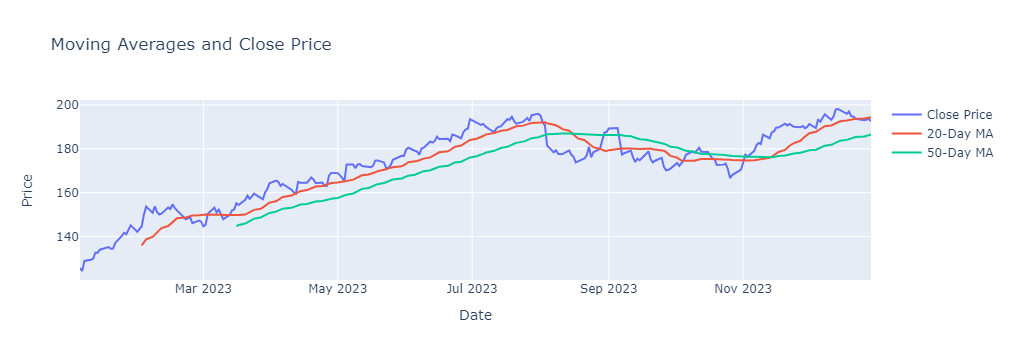

In [49]:
import plotly.graph_objects as go
# Calculate moving averages
df['MA20'] = df['close price'].rolling(window=20).mean()
df['MA50'] = df['close price'].rolling(window=50).mean()

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['close price'], name='Close Price'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA20'], name='20-Day MA'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA50'], name='50-Day MA'))
fig.update_layout(title='Moving Averages and Close Price', xaxis_title='Date', yaxis_title='Price')
fig.show()


# Bollinger Bands

Bollinger Bands are a type of price envelope developed by John Bollinger in the 1980s. They are volatility bands placed above and below a moving average. Volatility is based on the standard deviation, which changes as volatility increases and decreases. The bands automatically widen when volatility increases and narrow when volatility decreases.



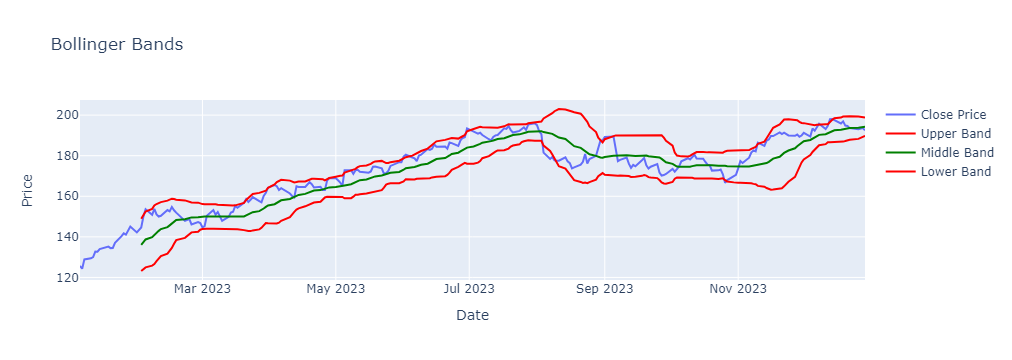

In [50]:
# Calculate Bollinger Bands
df['MA20'] = df['close price'].rolling(window=20).mean()
df['STD20'] = df['close price'].rolling(window=20).std()
df['Upper'] = df['MA20'] + (df['STD20'] * 2)
df['Lower'] = df['MA20'] - (df['STD20'] * 2)

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['close price'], name='Close Price'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Upper'], name='Upper Band', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA20'], name='Middle Band', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Lower'], name='Lower Band', line=dict(color='red')))
fig.update_layout(title='Bollinger Bands', xaxis_title='Date', yaxis_title='Price')
fig.show()


# Strategy Development

## Approach 1
The PortfolioOptimizer class aligns with dynamic programming and value iteration principles, focusing on optimizing portfolio value through informed decisions based on state transitions and their probabilities, without forecasting future prices. Here's a condensed overview of the approach:

### Dynamic Programming and Value Iteration: 
The class enhances portfolio value over time by making sequential decisions that are grounded in current and historical data. This approach is rooted in dynamic programming and value iteration, aiming to derive an optimal policy that maximizes expected returns.

### State Transitions and Probabilities:
#### State Classification: 
It categorizes each day into 'bull', 'flat', or 'bear' states according to daily returns, essential for tracking market state transitions.
#### Transition Probabilities: 
The class maintains a transition probability matrix, updated in a streaming fashion with each new piece of data. This process dynamically calculates the likelihood of moving between states ('bull', 'flat', 'bear'), based on observed historical transitions, thus avoiding any predictive modeling.
#### Decision Making Based on Probabilities: 
Buy decisions are predicated on the current state's transition probabilities. If the probability of moving to a 'bull' state from the current state exceeds that of moving to a 'bear' state, a buy decision is made for the subsequent day.

### Executing Trades and Portfolio Management:
#### Trade Execution: 
The portfolio value is updated according to the buy decision and the actual state transition, following a pre-defined value function.
#### Buy Indices: 
Identifies the days on which buy decisions are made, pinpointing optimal times for executing buy orders.

This streamlined approach ensures the PortfolioOptimizer continuously updates its model with incoming data, adhering to dynamic programming without relying on future price forecasts, thereby calculating transition probabilities in a streaming fashion to inform buy decisions.

In [111]:
import pandas as pd

class PortfolioOptimizer:
    def __init__(self):
        self.portfolio_value = 0  # Initialize portfolio value
        self.transition_probabilities = {'bull': {'bull': 0, 'flat': 0, 'bear': 0},
                                         'flat': {'bull': 0, 'flat': 0, 'bear': 0},
                                         'bear': {'bull': 0, 'flat': 0, 'bear': 0}}
        self.current_state = 'flat'  # Initialize current state
        self.buy_indices = []  # Initialize list to store buy indices

    def calculate_return(self, current_price, previous_price):
        return (current_price - previous_price) / previous_price

    def classify_state(self, returns):
        if returns >= 0.01:
            return 'bull'
        elif returns > -0.01:
            return 'flat'
        else:
            return 'bear'

    def update_transition_counts(self, previous_state, current_state):
        self.transition_probabilities[previous_state][current_state] += 1

    def calculate_transition_probabilities(self):
        for previous_state in self.transition_probabilities:
            total_transitions = sum(self.transition_probabilities[previous_state].values())
            for current_state in self.transition_probabilities[previous_state]:
                self.transition_probabilities[previous_state][current_state] /= total_transitions if total_transitions != 0 else 1 / 3

    def make_decision(self):
        bull_probability = self.transition_probabilities[self.current_state]['bull']
        bear_probability = self.transition_probabilities[self.current_state]['bear']
        if bull_probability > bear_probability:
            return 1  # Buy decision
        else:
            return -1  # Don't buy decision

    def execute_trade(self, decision):
        if decision == 1:  # Execute buy trade
            if self.current_state == 'bull':
                self.portfolio_value += 1
        elif decision == -1:  # Execute don't buy trade
            if self.current_state == 'bear':
                self.portfolio_value -= 1

    def optimize_portfolio(self, data):
        for i in range(1, len(data)):
            current_price = data.iloc[i]['FIBBG000B9XRY4']
            previous_price = data.iloc[i-1]['FIBBG000B9XRY4']
            returns = self.calculate_return(current_price, previous_price)
            current_state = self.classify_state(returns)
            if i > 1:
                previous_state = self.classify_state(self.calculate_return(data.iloc[i-1]['FIBBG000B9XRY4'], data.iloc[i-2]['FIBBG000B9XRY4']))
                self.update_transition_counts(previous_state, current_state)
            self.calculate_transition_probabilities()
            decision = self.make_decision()
            if decision == 1:  # If decision is to buy, store the index
                self.buy_indices.append(i)
            self.execute_trade(decision)
            self.current_state = current_state
        return self.portfolio_value, self.buy_indices

# Example usage
if __name__ == "__main__":
    # Load data from CSV file
    data = pd.read_csv("daily_closing_prices.csv")  # Adjust the path to your CSV file
    optimizer = PortfolioOptimizer()
    final_portfolio_value, buy_indices = optimizer.optimize_portfolio(data)
    print("Final Portfolio Value:", final_portfolio_value)
    print("Buy Indices:",buy_indices)


Final Portfolio Value: 27
Buy Indices: [3, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28, 30, 32, 34, 37, 40, 41, 42, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 133, 134, 135, 137, 142, 143, 144, 146, 160, 162, 164, 165, 166, 167, 168, 177, 178, 187, 188, 189, 190, 191, 192, 193, 194, 195, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 238, 239, 240, 241, 242]


## Approach 2 

In [112]:
import numpy as np

def calculate_returns(prices):
    """Calculate the percentage returns."""
    returns = np.diff(prices) / prices[:-1]
    return returns

def classify_state(return_value):
    """Classify a single day's state based on return."""
    if return_value >= 0.01:  # Adjusted for 10% threshold
        return 1  # Bull state
    elif return_value > -0.01:  # Adjusted for -10% threshold
        return 0  # Flat state
    else:
        return -1  # Bear state

def update_transition_probabilities(transitions, counts, from_state, to_state):
    """Update transition probabilities with a new observed transition."""
    from_index = int(from_state) + 1
    to_index = int(to_state) + 1
    transitions[from_index, to_index] += 1
    counts[from_index] += 1
    probabilities = np.divide(transitions, counts[:, None], out=np.zeros_like(transitions), where=counts[:, None] != 0)
    return probabilities

def dynamic_value_function_update(prices, transitions, counts):
    V = np.zeros(len(prices))  # Initialize the portfolio value function
    buy_indices = []
    states = np.zeros(len(prices))  # Include initial state as Flat

    # Initial state assumed as Flat (0)
    states[0] = 0

    for d in range(1, len(prices)):
        today_return = calculate_returns(prices[d-1:d+1])[0] if d > 1 else 0
        states[d] = classify_state(today_return)
        if d > 1:  # Start from second day to have previous state
            from_state = states[d-1]
            to_state = states[d]
            probabilities = update_transition_probabilities(transitions, counts, from_state, to_state)
            
            # Check for decision to buy based on transition probabilities
            # We focus on transitions from Flat to Bull or Bear for buying decisions
            if from_state == 0:  # From Flat state
                if probabilities[1, 2] > probabilities[1, 0]:  # If transition to Bull is more likely than to Bear
                    buy_indices.append(d)  # Decide to buy
                    # Update value based on expected transition
                    if to_state == 1:
                        V[d] = V[d-1] + 1
                    elif to_state == -1:
                        V[d] = V[d-1] - 1
                    else:
                        V[d] = V[d-1]
                else:
                    V[d] = V[d-1]
            else:
                V[d] = V[d-1]

    return V, buy_indices, states

# Initialize transition probabilities and counts
transitions = np.zeros((3, 3))  # For Bear, Flat, Bull transitions
counts = np.zeros(3)  # Count occurrences of each state
prices=df['close price'].to_numpy()
# Example: Uncomment and replace with actual price data
V, buy_indices, states = dynamic_value_function_update(prices, transitions, counts)
print(f"Final portfolio value: V(N) = {V[-1]}")
print(f"Optimal buy indices: {buy_indices}")


Final portfolio value: V(N) = 18.0
Optimal buy indices: [2, 4, 5, 7, 9, 10, 11, 15, 19, 20, 26, 27, 29, 32, 34, 35, 37, 38, 40, 44, 49, 51, 54, 55, 56, 58, 60, 62, 63, 65, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 92, 93, 95, 96, 98, 99, 102, 104, 105, 106, 107, 109, 111, 112, 114, 115, 116, 118, 119, 121, 122, 124, 125, 126, 127, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 141, 143, 144, 146, 149, 150, 151, 152, 153, 155, 157, 158, 159, 163, 166, 167, 168, 171, 172, 175, 176, 178, 180, 181, 182, 184, 185, 186, 188, 189, 190, 192, 193, 194, 195, 197, 198, 199, 200, 202, 203, 206, 208, 211, 214, 215, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 235, 237, 239, 240, 241, 242, 244, 245, 246, 247, 248]


## Approach 3

In [113]:
import pandas as pd
import numpy as np

# Placeholder for loading the data
# df = pd.read_csv('path_to_your_data.csv')  # Replace with your data loading line
# Example column in df: 'close price'

# Calculate daily returns
df['Return'] = df['close price'].pct_change()

# Classify the market state as Bull (1), Flat (0), or Bear (-1)
df['State'] = 0  # Default to Flat
df.loc[df['Return'] >= 0.01, 'State'] = 1  # Bull
df.loc[df['Return'] <= -0.01, 'State'] = -1  # Bear

# Initialize portfolio value
df['Portfolio_Value'] = 0
portfolio_value = 0

# Initialize transition probabilities matrix and state counts
transition_matrix = np.zeros((3, 3))  # Rows and columns for states -1, 0, 1
state_counts = np.zeros(3)  # Count occurrences of each state

# Iterate through each day
for i in range(1, len(df)):
    # Use iloc for positional indexing
    current_state = int(df.iloc[i-1]['State'])
    next_state = int(df.iloc[i]['State'])
    
    # Update state counts and transition matrix
    state_counts[current_state + 1] += 1
    transition_matrix[current_state + 1, next_state + 1] += 1

    # Calculate transition probabilities from the current state to all possible next states
    if state_counts[current_state + 1] != 0:  # Check to avoid division by zero
        transition_probs = transition_matrix[current_state + 1] / state_counts[current_state + 1]
    else:
        transition_probs = np.zeros(3)  # Default to no knowledge if no prior data

    # Decision making: Buy if likelihood of moving to a Bull state is higher than to a Bear state
    if transition_probs[2] > transition_probs[0]:  # Indices 2 and 0 correspond to Bull and Bear states, respectively
        if next_state == 1 and current_state == 0:
            portfolio_value += 1  # Increase portfolio value if moving from Flat to Bull
        elif next_state == -1 and current_state == 0:
            portfolio_value -= 1  # Decrease portfolio value if moving from Flat to Bear

    df.iloc[i, df.columns.get_loc('Portfolio_Value')] = portfolio_value

    # Print the current transition probability matrix
    print(f"Transition Probability Matrix (Step {i}):")
    print(transition_matrix / state_counts[:, None])

# Output the final portfolio value and optimal buy indices
final_portfolio_value = df.iloc[-1]['Portfolio_Value']
optimal_buy_indices = [i for i, v in enumerate(df['Portfolio_Value'].diff() > 0) if v]

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Optimal Buy Indices: {optimal_buy_indices}")


Transition Probability Matrix (Step 1):
[[nan nan nan]
 [ 1.  0.  0.]
 [nan nan nan]]
Transition Probability Matrix (Step 2):
[[ 0.  0.  1.]
 [ 1.  0.  0.]
 [nan nan nan]]
Transition Probability Matrix (Step 3):
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Transition Probability Matrix (Step 4):
[[0.  0.  1. ]
 [0.5 0.5 0. ]
 [0.  1.  0. ]]
Transition Probability Matrix (Step 5):
[[0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         1.         0.        ]]
Transition Probability Matrix (Step 6):
[[0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         1.         0.        ]]
Transition Probability Matrix (Step 7):
[[0.   0.   1.  ]
 [0.25 0.25 0.5 ]
 [0.   1.   0.  ]]
Transition Probability Matrix (Step 8):
[[0.   0.   1.  ]
 [0.25 0.25 0.5 ]
 [0.   1.   0.  ]]
Transition Probability Matrix (Step 9):
[[0.  0.  1. ]
 [0.2 0.4 0.4]
 [0.  1.  0. ]]
Transition Probability Matrix (Step 10):
[[0.         0.         1.        ]
 [0.16666667 0

/tmp/ipykernel_101/3204253006.py:51: RuntimeWarning:

invalid value encountered in true_divide



## Approach 4

In [114]:
import pandas as pd
import numpy as np

# Placeholder for loading the data
# df = pd.read_csv('path_to_your_data.csv')  # Replace with your data loading line
# Example column in df: 'close price'

# Calculate daily returns
df['Return'] = df['close price'].pct_change()

# Classify the market state as Bull (1), Flat (0), or Bear (-1)
df['State'] = 0  # Default to Flat
df.loc[df['Return'] >= 0.01, 'State'] = 1  # Bull
df.loc[df['Return'] <= -0.01, 'State'] = -1  # Bear

# Initialize portfolio value
df['Portfolio_Value'] = 0
portfolio_value = 0

# Initialize transition probabilities matrix and state counts
transition_matrix = np.zeros((3, 3))  # Rows and columns for states: Bear, Flat, Bull
state_counts = np.zeros(3)  # Count occurrences of each state

# Iterate through each day
for i in range(1, len(df)):
    # Use iloc for positional indexing
    current_state = int(df.iloc[i-1]['State'])
    next_state = int(df.iloc[i]['State'])
    
    # Update state counts and transition matrix
    state_counts[current_state + 1] += 1
    transition_matrix[current_state + 1, next_state + 1] += 1

    # Calculate transition probabilities from the current state to all possible next states
    if state_counts[current_state + 1] != 0:  # Check to avoid division by zero
        transition_probs = transition_matrix[current_state + 1] / state_counts[current_state + 1]
    else:
        transition_probs = np.zeros(3)  # Default to no knowledge if no prior data

    # Decision making: Buy if likelihood of moving to Bull state is higher than moving to Bear state
    if transition_probs[2] > transition_probs[0]:  # Indices 2 and 0 correspond to Bull and Bear states, respectively
        if next_state == 1 and current_state != 1:  # Buy only if not already in Bull state
            portfolio_value += 1  # Increase portfolio value if moving to Bull
        elif next_state == -1:  # Sell if moving to Bear state
            portfolio_value -= 1  # Decrease portfolio value

    df.iloc[i, df.columns.get_loc('Portfolio_Value')] = portfolio_value

    # Print the current transition probability matrix
    print(f"Transition Probability Matrix (Step {i}):")
    print(transition_matrix / state_counts[:, None])

# Output the final portfolio value and optimal buy indices
final_portfolio_value = df.iloc[-1]['Portfolio_Value']
optimal_buy_indices = [i for i, v in enumerate(df['Portfolio_Value'].diff() > 0) if v]

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Optimal Buy Indices: {optimal_buy_indices}")


Transition Probability Matrix (Step 1):
[[nan nan nan]
 [ 1.  0.  0.]
 [nan nan nan]]
Transition Probability Matrix (Step 2):
[[ 0.  0.  1.]
 [ 1.  0.  0.]
 [nan nan nan]]
Transition Probability Matrix (Step 3):
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Transition Probability Matrix (Step 4):
[[0.  0.  1. ]
 [0.5 0.5 0. ]
 [0.  1.  0. ]]
Transition Probability Matrix (Step 5):
[[0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         1.         0.        ]]
Transition Probability Matrix (Step 6):
[[0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         1.         0.        ]]
Transition Probability Matrix (Step 7):
[[0.   0.   1.  ]
 [0.25 0.25 0.5 ]
 [0.   1.   0.  ]]
Transition Probability Matrix (Step 8):
[[0.   0.   1.  ]
 [0.25 0.25 0.5 ]
 [0.   1.   0.  ]]
Transition Probability Matrix (Step 9):
[[0.  0.  1. ]
 [0.2 0.4 0.4]
 [0.  1.  0. ]]
Transition Probability Matrix (Step 10):
[[0.         0.         1.        ]
 [0.16666667 0

/tmp/ipykernel_101/961377700.py:51: RuntimeWarning:

invalid value encountered in true_divide



## Approach 5

In [115]:
import numpy as np
import pandas as pd

# Assuming df['close price'] is your DataFrame's column with daily close prices
# Replace 'df' with actual DataFrame name if different
prices = df['close price'].to_numpy()

# Calculate daily returns and classify states
returns = np.diff(prices) / prices[:-1]
returns = np.insert(returns, 0, 0)  # Insert a 0 return for the first day
states = np.where(returns >= 0.01, 1, np.where(returns > -0.01, 0, -1))

# Initialize transition count matrix for streaming updates
transition_counts = np.zeros((3, 3))  # Rows: from_state (-1, 0, 1), Columns: to_state (-1, 0, 1)

# Update transition counts in a streaming fashion
for i in range(1, len(states)):
    from_state = states[i - 1] + 1  # Adjust index for 0-based indexing
    to_state = states[i] + 1  # Adjust index for 0-based indexing
    transition_counts[from_state, to_state] += 1

# Convert counts to probabilities
transition_probs = transition_counts / np.maximum(transition_counts.sum(axis=1, keepdims=True), 1)  # Avoid division by zero

# Value function and policy initialization
V = np.zeros(len(states))  # Portfolio value for each day
policy = np.zeros(len(states), dtype=bool)  # Buy (True) or Not Buy (False) decision

# Value iteration in reverse (from day N-1 to 1)
for i in range(len(states)-2, -1, -1):
    # Update transition probabilities based on the data up to day i (streaming fashion)
    if i < len(states) - 2:  # Avoid recalculating on the first iteration
        from_state = states[i] + 1
        to_state = states[i + 1] + 1
        transition_counts[from_state, to_state] += 1
        transition_probs = transition_counts / np.maximum(transition_counts.sum(axis=1, keepdims=True), 1)
    
    if states[i] == 0:  # Considering buying only on Flat days
        # Calculate the likelihood of value additive (to Bull) vs value reductive (to Bear) state transitions
        prob_to_bull = transition_probs[1, 2]  # From Flat to Bull
        prob_to_bear = transition_probs[1, 0]  # From Flat to Bear
        
        # Decide to buy if more likely to transition to Bull state than Bear state
        if prob_to_bull > prob_to_bear:
            V[i] = V[i + 1] + 1  # Assuming additive value for moving to Bull state
            policy[i] = True
        else:
            V[i] = V[i + 1]
    else:
        V[i] = V[i + 1]

# Final portfolio value and buy indices
final_portfolio_value = V[0]
buy_indices = [i for i, buy in enumerate(policy) if buy]

print("Final Portfolio Value:", final_portfolio_value)
print("Buy Indices:", buy_indices)


Final Portfolio Value: 158.0
Buy Indices: [0, 3, 4, 6, 8, 9, 10, 14, 18, 19, 25, 26, 28, 31, 33, 34, 36, 37, 39, 43, 48, 50, 53, 54, 55, 57, 59, 61, 62, 64, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 85, 86, 88, 89, 90, 91, 92, 94, 95, 97, 98, 101, 103, 104, 105, 106, 108, 110, 111, 113, 114, 115, 117, 118, 120, 121, 123, 124, 125, 126, 128, 129, 130, 131, 133, 134, 136, 137, 138, 139, 140, 142, 143, 145, 148, 149, 150, 151, 152, 154, 156, 157, 158, 162, 165, 166, 167, 170, 171, 174, 175, 177, 179, 180, 181, 183, 184, 185, 187, 188, 189, 191, 192, 193, 194, 196, 197, 198, 199, 201, 202, 205, 207, 210, 213, 214, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 232, 234, 236, 238, 239, 240, 241, 243, 244, 245, 246, 247]


## Apprach 6

In [116]:
import numpy as np

# Assuming 'prices' is a numpy array containing daily closing prices for a stock
prices = df['close price'].to_numpy()  # Use actual DataFrame column

# Calculate daily returns and classify states
returns = np.diff(prices) / prices[:-1]
returns = np.insert(returns, 0, 0)  # Insert a 0 return for the first day
states = np.where(returns >= 0.01, 1, np.where(returns > -0.01, 0, -1))

# Initialize transition counts and probabilities matrix
transition_counts = np.zeros((3, 3))  # From state (rows) to state (columns)
n_states = len(states)

# Value initialization
V = np.zeros(n_states)  # Portfolio value
buy_decision = np.zeros(n_states, dtype=bool)  # Whether to buy

for i in range(1, n_states - 1):  # Adjusted to n_states - 1 to avoid index out of bounds
    # Update transition counts
    from_state = states[i-1] + 1  # Adjusting index to start from 0
    to_state = states[i] + 1  # Adjusting index to start from 0
    transition_counts[from_state, to_state] += 1
    
    # Calculate transition probabilities in a streaming fashion
    transition_probs = transition_counts / np.maximum(transition_counts.sum(axis=1, keepdims=True), 1)  # Avoid division by zero
    
    # Decision-making for day i based on the value function criteria
    if states[i] == 0:  # Considering buying on days following a Flat state
        prob_to_bull = transition_probs[1, 2]  # Probability from Flat to Bull
        prob_to_bear = transition_probs[1, 0]  # Probability from Flat to Bear
        
        if prob_to_bull > prob_to_bear:  # If more likely to go Bull
            buy_decision[i] = True
            if i < n_states - 1:  # Ensure we don't look beyond the last index
                if states[i+1] == 1:
                    V[i+1] = V[i] + 1  # Value increases if it goes Bull
                elif states[i+1] == -1:
                    V[i+1] = V[i] - 1  # Value decreases if it goes Bear
                else:
                    V[i+1] = V[i]  # No change if it stays Flat or decision is not to buy
        else:
            V[i+1] = V[i]  # No buy decision
    else:
        V[i+1] = V[i]  # Carry forward value for non-Flat states

# Determine the final portfolio value and days to buy
final_portfolio_value = V[-1]
buy_days = np.where(buy_decision)[0]

print("Final Portfolio Value:", final_portfolio_value)
print("Days to Place Buy Order:",buy_days
     )

Final Portfolio Value: 15.0
Days to Place Buy Order: [  8   9  10  14  18  19  25  26  28  31  33  34  36  37  39  43  48  50
  53  54  55  57  59  61  62  64  66  67  69  70  71  72  73  74  75  76
  77  79  80  81  82  83  85  86  88  89  90  91  92  94  95  97  98 101
 103 104 105 106 108 110 111 113 114 115 117 118 120 121 123 124 125 126
 128 129 130 131 133 134 136 137 138 139 140 142 143 145 148 149 150 151
 152 154 156 157 158 162 165 166 167 170 171 174 175 177 179 180 181 183
 184 185 187 188 189 191 192 193 194 196 197 198 199 201 202 205 207 210
 213 214 216 218 219 220 221 222 223 224 225 226 227 228 229 230 232 234
 236 238 239 240 241 243 244 245 246 247]


## Approach 7

In [119]:

import pandas as pd
import numpy as np

class PortfolioOptimizer:
    def __init__(self, data):
        self.data = data
        self.states = self.classify_states()
        self.value_function = np.zeros(len(data))
        self.buy_indices = []

    def classify_states(self):
        # Calculate daily returns
        returns = self.data['FIBBG000B9XRY4'].pct_change()
        # Classify states based on returns
        states = returns.apply(lambda r: 1 if r >= 0.01 else (-1 if r <= -0.01 else 0))
        return states

    def optimize_portfolio(self):
        # Iterate through each day
        for i in range(1, len(self.data)):
            # Assume we do not place a buy order
            no_buy_value = self.value_function[i-1]
            # Assume we place a buy order, and check tomorrow's state
            if i < len(self.data) - 1:
                tomorrow_state = self.states.iloc[i+1]
                if tomorrow_state == 1 and self.states.iloc[i] == 0:
                    buy_value = self.value_function[i-1] + 1
                elif tomorrow_state == -1 and self.states.iloc[i] == 0:
                    buy_value = self.value_function[i-1] - 1
                else:
                    buy_value = self.value_function[i-1]
            else:
                buy_value = no_buy_value  # Can't buy on the last day

            # Choose the action that maximizes the portfolio value
            if buy_value > no_buy_value:
                self.value_function[i] = buy_value
                self.buy_indices.append(i)
            else:
                self.value_function[i] = no_buy_value

        return self.value_function[-1], self.buy_indices

# Example usage
if __name__ == "__main__":
    # Load data from CSV file
    data = pd.read_csv("daily_closing_prices.csv")  # Adjust the path to your CSV file
    optimizer = PortfolioOptimizer(data)  # Create instance of PortfolioOptimizer
    final_portfolio_value, buy_indices = optimizer.optimize_portfolio()  # Optimize portfolio
    print("\nFinal Portfolio Value:", final_portfolio_value)  # Print final portfolio value
    print("Optimal Buy Indices:", buy_indices)  # Print optimal buy indices



Final Portfolio Value: 40.0
Optimal Buy Indices: [5, 7, 11, 15, 20, 27, 29, 40, 49, 51, 58, 60, 68, 78, 84, 87, 93, 99, 102, 107, 109, 112, 116, 119, 122, 132, 141, 159, 163, 176, 186, 190, 206, 208, 211, 215, 217, 231, 233, 237]


# Backtesting
Test our Strategy: Quantrocket provides tools for backtesting your strategies against historical data. Use this feature to test your model's performance, specifically its ability to maximize the portfolio value through strategic buy orders

Before risking any real money, it's crucial to test your strategy against historical data to see how it would have performed in the past. This can be done using backtesting software or writing your own backtesting scripts in Python.

Minimalist Approach: Use Python libraries such as pandas for data manipulation and backtrader or QuantConnect for backtesting. These tools allow you to simulate trading decisions based on historical data and evaluate the performance of your strategy

# Backtest of a Moving Average Crossover Strategy

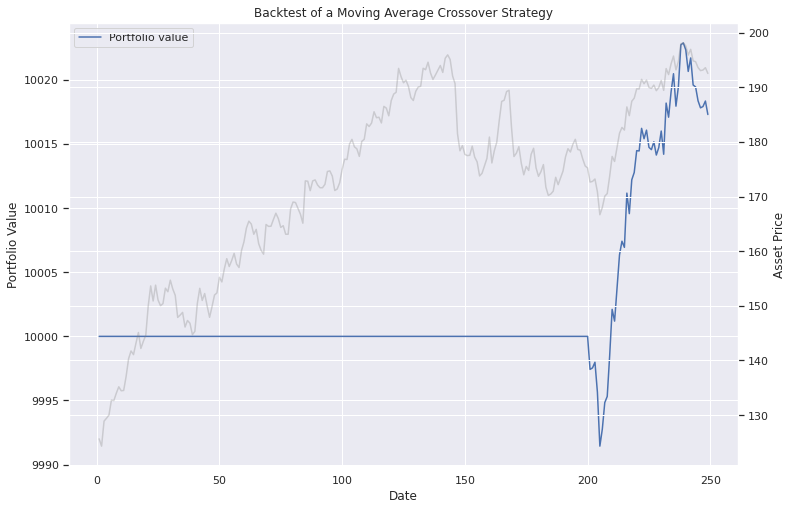

Cumulative Returns: 0.17%


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'close price' and a DatetimeIndex

# Calculate moving averages
df['Short_MA'] = df['close price'].rolling(window=50).mean()
df['Long_MA'] = df['close price'].rolling(window=200).mean()

# Initialize signal column
df['Signal'] = 0

# Update 'Signal' based on the moving averages
df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1, 0)

# Compute 'Position' as the day-to-day difference in 'Signal'
df['Position'] = df['Signal'].diff()

# Initialize portfolio simulation
initial_capital = float(10000.0)
positions = pd.DataFrame(index=df.index).fillna(0.0)
positions['Asset'] = df['Signal']

# Simulate the portfolio
portfolio = positions.multiply(df['close price'], axis=0)
pos_diff = positions.diff()

portfolio['Holdings'] = (positions.multiply(df['close price'], axis=0)).sum(axis=1)
portfolio['Cash'] = initial_capital - (pos_diff.multiply(df['close price'], axis=0)).sum(axis=1).cumsum()
portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']
portfolio['Returns'] = portfolio['Total'].pct_change()

# Plot the performance
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(portfolio['Total'], label='Portfolio value')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value')
ax2 = ax1.twinx()
ax2.plot(df['close price'], color='grey', alpha=0.3)
ax2.set_ylabel('Asset Price')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

plt.title('Backtest of a Moving Average Crossover Strategy')
plt.show()

# Calculate cumulative returns
cumulative_returns = (portfolio['Total'].iloc[-1] / portfolio['Total'].iloc[0]) - 1

print(f"Cumulative Returns: {cumulative_returns:.2%}")


# AAPL Daily Returns State Classification

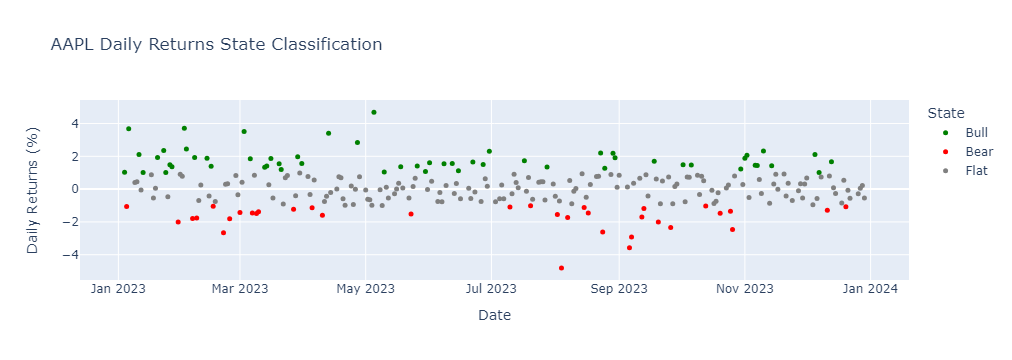

In [16]:
# Map state numeric values to textual descriptions
df['State'] = states
state_map = {-1: 'Bear', 0: 'Flat', 1: 'Bull'}
df['State'] = df['State'].map(state_map)

import plotly.express as px

# With 'State' now containing textual descriptions, proceed to plot
fig = px.scatter(df, x='Date', y='Daily Returns', color='State', title='AAPL Daily Returns State Classification',
                 color_discrete_map={'Bear': 'red', 'Flat': 'grey', 'Bull': 'green'})  # Optional: specific colors for each state
fig.update_traces(marker=dict(size=5))
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Daily Returns (%)')
fig.show()
